# ASTR 202 -- Random Numbers Tutorial

When performing numerical simulations or working with statistics, we use (pseudo-)random number generators to mimic random processes in nature. In this tutorial, we will examine methods for generating random numbers and apply them in ways that will be helpful for the class final project.

In [1]:
!python3 -m pip install healpy

### Importing modules

For random number generation, we will use the Numpy library.  For plotting, we will use the Matplot library. And we will make use of the [HealPix Python](https://healpy.readthedocs.io/en/latest/) library healpy.

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import scipy.special as sp

### Declaring a random number generator instance

Numpy provides the `numpy.random` submodule for generating random numbers. Starting with numpy 1.17, the recommendation for declaring and using a random number generator is as follows:

In [88]:
#import the default random number generator
from numpy.random import default_rng

#make a seed for reproducibility
seed = 1337

#create an instance of the default random number generator
rng = default_rng(seed)

### Pulling random numbers

Let's go ahead and pull a bunch of uniformly distributed random numbers and then histogram them to see whether the RNG is working....

##### Uniform random variates

In [86]:
#how many random numbers to pull?
n_random = 100000

#pull an array of uniformly-distributed random [0,1]
x = rng.uniform(0,1,n_random)

print(x[1])

0.5443418330501375


Histogram the results:

Text(0, 0.5, 'y')

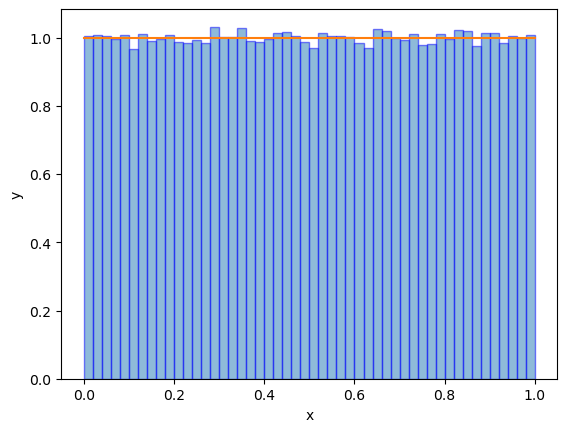

In [87]:
#how many bins to use?
nbins = 50

#use matplotlib.pyplot.hist
n,bins,patches = plt.hist(x,bins=nbins,density=True,ec="blue",alpha=0.5)

#overplot a line
xx = np.linspace(0,1,nbins)
yy = np.full(nbins,1.)
plt.plot(xx,yy)
plt.xlabel('x')
plt.ylabel('y')

The scatter owes to random variations in the distribution of points between [0,1].

##### Gaussian-distributed random variates

Let's pull random variates from a Gaussian with unit rms centered at 0.

In [5]:
#how many random numbers to pull?
n_random = 100000

#pull an array of gaussian-distributed random numbers with zero mean and unit variance
x = rng.normal(0,1,n_random)
print(x.max(),x.min())

4.029198714015424 -4.239020925072361


Histogram the results:

Text(0, 0.5, 'y')

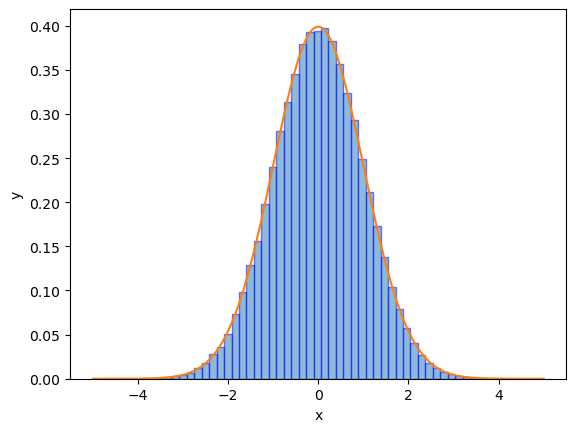

In [6]:
#how many bins to use?
nbins = 50

#use matplotlib.pyplot.hist
n,bins,patches = plt.hist(x,bins=nbins,density=True,ec="blue",alpha=0.5)

#overplot a line
xx = np.linspace(-5,5,1000)
yy = 1./((2.*np.pi)**0.5)* np.exp(-0.5*xx**2)
plt.plot(xx,yy)
plt.xlabel('x')
plt.ylabel('y')

## Drawing random directions -- THE WRONG WAY :)

If we have angles $\theta=[0,\pi]$ and $\phi=[0,2\pi]$, to pick a random direction, one might try to uniformly draw from $\theta$ and $\phi$.  Let's do that and see what happens.

In [76]:
#how many directions?
n_dir = 100000

#draw random phi
phi = 2.*np.pi*rng.uniform(0,1,n_dir)

#draw random theta
theta = np.pi*rng.uniform(0,1,n_dir)

So far, so good, but let's histogram them on the sphere using `healpy`.

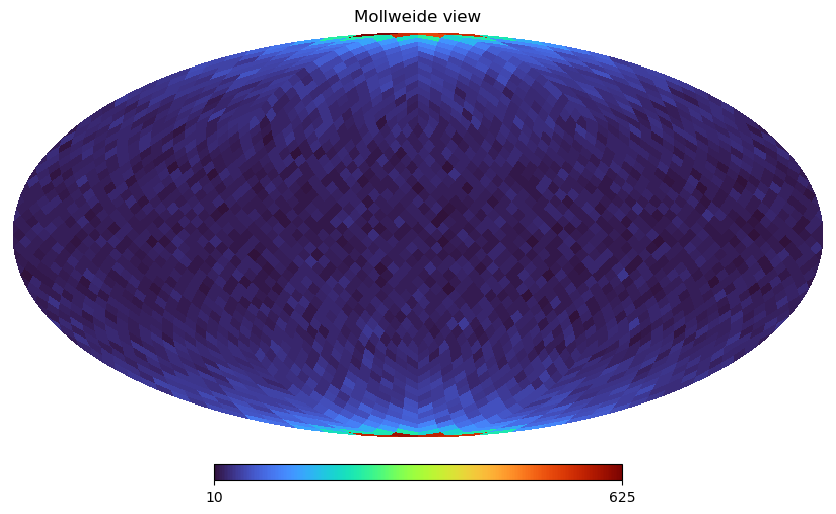

In [77]:
NSIDE = 16
m = np.zeros(hp.nside2npix(NSIDE))

pix = hp.ang2pix(NSIDE,theta,phi)

for i in range(n_dir):
    m[pix[i]] += 1.0
    
hp.mollview(m,"Incorrect Random Directions",cmap="turbo")

#### WHOA!
Pulling in $\theta$ and $\phi$ directly leads to overpopulation of the poles.  That's because differential solid angle is not $d\theta d\phi$, but $\sin\theta d\theta d\phi$.

## Drawing random directions -- THE RIGHT WAY :)

If we have angles $\theta=[0,\pi]$ and $\phi=[0,2\pi]$. To pick a random direction, we should draw uniformly from $\phi$, and uniformly from $\sin\theta$. To pull from $\sin\theta$, we can draw uniform variates $\xi_\phi=[0,1]$ and then set $\theta = \cos^{-1}(2\xi_\theta -1)$.  Let's do that and see what happens.

In [82]:
#how many directions?
n_dir = 100000

#draw random phi
phi = 2.*np.pi*rng.uniform(0,1,n_dir)

#draw random theta
theta = np.arccos(2.*rng.uniform(0,1,n_dir)-1)

Now histogram them on the sphere using `healpy`.

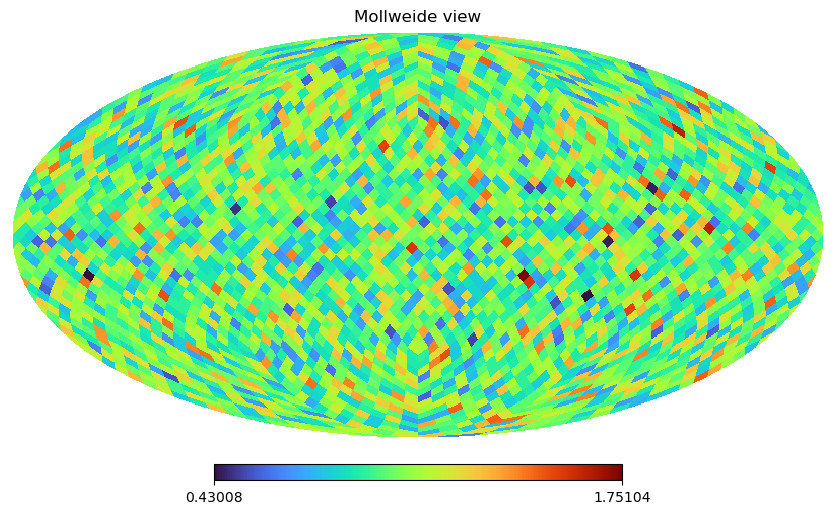

In [83]:
NSIDE = 16
m = np.zeros(hp.nside2npix(NSIDE))

pix = hp.ang2pix(NSIDE,theta,phi)

for i in range(n_dir):
    m[pix[i]] += 1.0
    
hp.mollview(m*hp.nside2npix(NSIDE)/float(n_dir),"Correct Random Directions",cmap="turbo")

OK, this looks good, but how close are we?  What's the normalized mean (adjusting for number of healpix on the sky and the number of samples)?  It should hopefully be unity!

In [15]:
print(np.mean(m*hp.nside2npix(NSIDE)/float(n_dir)))

1.0


### YAY!

# Pulling random numbers from generic distributions

Fortunately, numpy has a wide range of interesting distributions from which we can pull random numbers, including:

*beta*, *binomial*, *chisquare*, *dirichlet*, *exponential*, *gamma*, *geometric*, *lognormal*, *normal*, *uniform*, etc., etc.

But if we want to create our own probability distributions for pulling random variates, how do we do that?

Consider the probability distribution function $p(x)$.  We know that the function is normalized such that

$\int_{-\infty}^{\infty} p(x)dx = 1$

We can define the cumulative distribution function $P(<x)$ as

$P(<x) = \int_{-\infty}^{x} p(x)dx$

If we want to draw random variates from $p(x)$, we can instead pull random variates $\xi_p=[0,1]$ and then convert to the $x$ where $P(<x) = \xi_p$.


#### Defining your PDF

Let's define the PDF from which we will draw random variates.  Let's pick an arbitrary function for which we can compute the integral. Let's use a unit normal gaussian.

In [10]:
def pdf(x):
    return 1./(2.*np.pi)**0.5 * exp(-0.5*x**2)

The CDF for the unit normal gaussian is an error function:

$P(<x) = \frac{1}{2}\left[ 1 + \mathrm{erf}\left(\frac{x}{\sqrt{2}}\right)\right]$

We can use `scipy.special.erf` to compute this.

In [13]:
def cdf(x):
    return 0.5*(1. + sp.erf(x/2**0.5))

Let's plot the CDF to have a look:

Text(0, 0.5, '$P(<x)$')

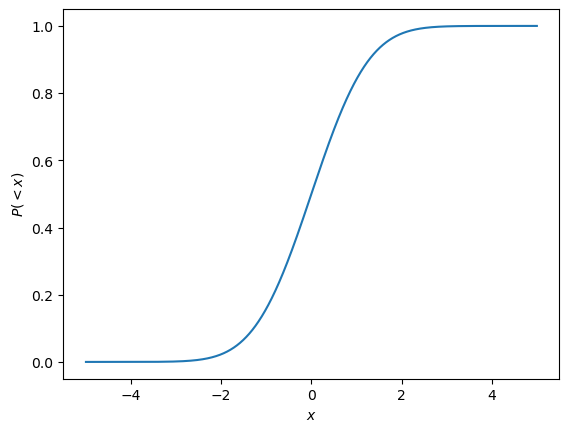

In [14]:
#how many samples?
n_x = 100000

xx = np.linspace(-5,5,n_x)
yy = cdf(xx)
plt.plot(xx,yy)
plt.xlabel(r'$x$')
plt.ylabel(r'$P(<x)$')

### Sampling from a PDF

OK, we have an array of x and the corresponding CDF values tabulated.  We can use this to generate approximate random variates from the PDF by drawing uniform random variates $\xi_p=[0,1]$ and then looking up the value of $x$ corresponding to $P=\xi_p$.

In [15]:
# How many random variates?
n_rand = 10000

#Get the xi_p=[0,1]
xi_p = rng.uniform(0,1,n_rand)

#get the indices 
idx = np.searchsorted(yy,xi_p,side='left')

#check whether the range of xx is OK
n_zero = np.where(idx==0)[0]
if(len(n_zero)>0):
    print("Expand the range of x",len(n_zero))

#perform inverse lookup with linear interpolation
x_pdf = xx[idx-1] + (xi_p-yy[idx-1])/(yy[idx]-yy[idx-1]) * (xx[idx]-xx[idx-1])

#what is the minimum, maximum, and mean value of x_pdf?
print(np.min(x_pdf),np.max(x_pdf),np.mean(x_pdf))

-4.0966993056178165 3.4877533639805858 -0.007981005330894023


Now for the moment of truth -- let's histogram $x_pdf$ and see if they are distributed like a unit normal gaussian.

Text(0, 0.5, 'y')

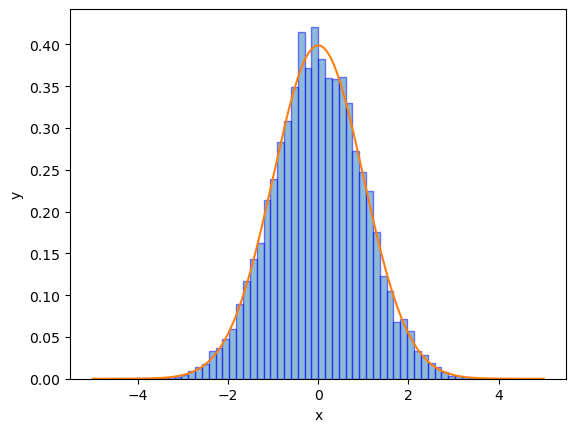

In [16]:
#how many bins to use?
nbins = 50

#use matplotlib.pyplot.hist
n,bins,patches = plt.hist(x_pdf,bins=nbins,density=True,ec="blue",alpha=0.5)

#overplot a line
xx = np.linspace(-5,5,1000)
yy = 1./((2.*np.pi)**0.5)* np.exp(-0.5*xx**2)
plt.plot(xx,yy)
plt.xlabel('x')
plt.ylabel('y')

### WHOA